# Presentación

## Detalle del proyecto

***Tecnicatura Universitaria en Inteligencia Artificial***

***Procesamiento de lenguaje natural - IA.42***

---

**Estudiante**: Fabio Giampaoli


**Fechas**:
- Primera entrega: 18-12-2023
- Segunda entrega: 20-02-2024

---

## Resumen

Este proyecto consiste en la creación de un modelo de lenguaje como asistente para conversar con lenguaje natural sobre algún dominio de interés a alección, y la investigación de la posibilidad de convertirlo en un sistema multiagente que pueda conectar con diversas herramientas.

En este caso, mi interés es que el agente sea experto en Genexus. Genexus en un entorno de desarrollo de software que mediante un lenguaje de programación simiplificado e integraciones con otras herramientas, se puede generar código fuente para compilar y desplegar aplicaciones.

El objetivo es que el agente pueda tener a disposición la documentación oficial de Genexus para que pueda mantener una conversación al respecto como si Genexus fuera parte de su fuente de su conocimiento, para finalmente darle al usuario que interactua la sensación de que el agente puede ayudar a resolver dudas y problemas relacionados.

El modelo conversacional alimentara su contexto mediante diferentes fuentes de datos. Las tres fuentes principales que tomara serán:
- Wiki de Genexus: mediante extracción del texto de las páginas de la documentación oficial mediante técnicas de scrapping.
- Cursos de Genexus: Genexus posee videos que enseñan desde los conceptos más básicos hasta conceptos y metodológias avanzadas. Los video son acompañados por documentos pdf como transcripciones de los videos.
- WikiData: Es una base de conocimiento de grafos abierta de dominio general que dotará al modelo de conocimiento general de cualquier tópico en general.

# Resolución

## Entorno


Es necesario preparar el entorno de programación con las librerías y dependencias que necesitará el proyecto para ser desarrollado con las habilidades adquiridas durante el cursado de la asignatura.

### Versiones

In [ ]:
!python --version

Python 3.10.12


In [ ]:
%%capture
# instalación de modulos
!pip install langchain
!pip install sentence-transformers
!pip install gdown==4.6.3
!pip install textblob
!pip install qwikidata
!pip install SPARQLWrapper
!pip install -U deep-translator
!pip install faiss-gpu
!pip install typing-extensions
!pip install pypdf
!pip install sentence_splitter
!pip install llama-index
!pip install PyMuPDF
!pip install playwright==1.41.0
!playwright install

### Error de dependencia

Existe un error al importar librerias que hace uso de este archivo en Python ya que es de uso común en librerías de procesamiento de lenguaje natural. Esta es una forma de solucionarlo en un entorno virtual como en Google colab.

In [ ]:
!cat /usr/local/lib/python3.10/dist-packages/openai/_utils/_streams.py

from typing import Any
from typing_extensions import Iterator, AsyncIterator


def consume_sync_iterator(iterator: Iterator[Any]) -> None:
    for _ in iterator:
        ...


async def consume_async_iterator(iterator: AsyncIterator[Any]) -> None:
    async for _ in iterator:
        ...


In [ ]:
%%writefile /usr/local/lib/python3.10/dist-packages/openai/_utils/_streams.py
from typing import Any
from typing_extensions import AsyncIterator
from typing import Iterator

def consume_sync_iterator(iterator: Iterator[Any]) -> None:
    for _ in iterator:
        ...

async def consume_async_iterator(iterator: AsyncIterator[Any]) -> None:
    async for _ in iterator:
        ...

Overwriting /usr/local/lib/python3.10/dist-packages/openai/_utils/_streams.py


### Importaciones

In [ ]:
# procesamiento
import pandas as pd
import numpy as np
import torch
import re
import json
from tqdm import tqdm
from datetime import datetime
from torch import nn

# extraccion
from textblob import TextBlob
from SPARQLWrapper import SPARQLWrapper, JSON
from bs4 import BeautifulSoup
import requests
from qwikidata.sparql import return_sparql_query_results
import fitz

# archivos
import zipfile
import shutil
import os
import io

# acceso
from google.colab import auth
from googleapiclient.discovery import build
import urllib.request
from googleapiclient.http import MediaIoBaseDownload
from oauth2client.client import GoogleCredentials
from pydrive2.auth import GoogleAuth
from google.colab import drive
from pydrive2.drive import GoogleDrive

# lenguaje
import spacy
import nltk
from sentence_transformers import SentenceTransformer, util
from langchain.vectorstores import FAISS
from langchain_core.documents.base import Document
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from llama_index.embeddings import LangchainEmbedding
from llama_index import ServiceContext
from llama_index import VectorStoreIndex, SimpleDirectoryReader
from llama_index.text_splitter import SentenceSplitter
from sentence_splitter import SentenceSplitter


# utilidades
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from deep_translator import GoogleTranslator

### Descargas

In [ ]:
# descargas
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('punkt')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

### Acceso rápido

Estas celdas son de utilidad para una preparación rapida del entorno con el fin de ejecutar el modelo de lenguaje evitando librerias que no son usadas en solo la tarea de cargar las fuentes con los datos ya preprocesados y ejecutar el modelo conversacional.

In [5]:
%%capture
# instalación de modulos
!pip install langchain
!pip install sentence-transformers
!pip install llama-index
!pip install faiss-gpu
!pip install textblob
!pip install qwikidata
!pip install SPARQLWrapper
!pip install -U deep-translator

In [8]:
# procesamiento
import pandas as pd
import numpy as np
import torch
import re
from torch import nn

# extraccion
import requests
from textblob import TextBlob
from SPARQLWrapper import SPARQLWrapper, JSON
from qwikidata.sparql import return_sparql_query_results

# archivos
import zipfile
import shutil
import os
import pickle
from google.colab import userdata

# lenguaje
import nltk
from sentence_transformers import SentenceTransformer, util
from langchain.vectorstores import FAISS
from langchain_core.documents.base import Document
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from llama_index.embeddings import LangchainEmbedding
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index.text_splitter import SentenceSplitter
from llama_index import StorageContext, load_index_from_storage

# utilidades
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from deep_translator import GoogleTranslator

In [7]:
# descargas
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download('brown')

stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


## Fuentes

Cada sección debajo se enfoca en la extracción y recuperación de las tres fuentes de datos de interés. Al final, se encuentra un acceso rápido a los datos preprocesados con el fin de consumirlos directamente en lugar de procesarlos desde cero con cada activación del entorno.

### Datos tabulares

La Wiki de Genexus posee una estructura muy conveniente para la extracción del contenido de sus páginas. Por lo que se automatizará la extracción de los contenidos de los menues principales de la Wiki, con el fin de generar una tabla o dataframe que almacene gran parte del conocimiento que el estos menues han sido escritos de forma ordenada y estandar.

#### Tópicos

La wiki de Genexus se divide en tópicos. Cada tópico tiene un menú asociado a las diferentes páginas de ese tópico en particular. Por lo que el objetivo es situarse en los menues principales de cada tópico de interés (seleccionados manualmente), y extraer de cada menu los links a cada una de las páginas de ese tópico.

Asi luce la estructura tipica de un tópico de Genexus:

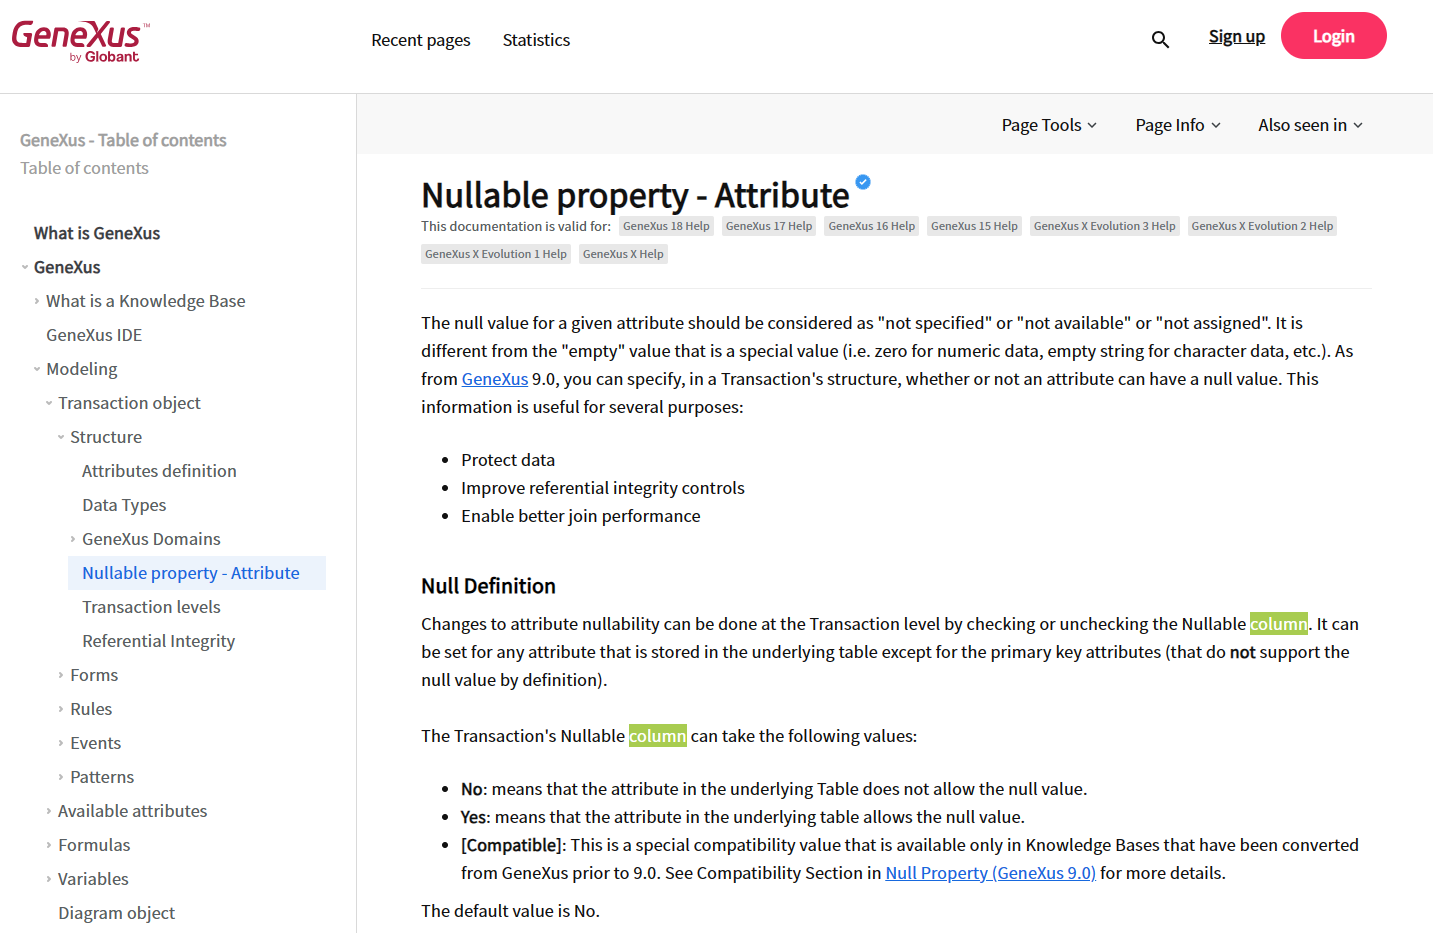

In [ ]:
def extract_menu(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')

    # Este id particular es cual contiene la estructura de arbol del menu del topico
    div_element = soup.find('div', {'id': 'MPW0034BODY'})

    if div_element:
        links_dict = {}

        # extrae las url de las paginas a los que apuntan el menu
        for anchor_tag in div_element.find_all('a'):
            title = anchor_tag.text.strip()
            url = anchor_tag['href']
            links_dict[title] = 'https://wiki.genexus.com' + url

        return links_dict
    else:
        print("Div with id 'MPW0034BODY' not found.")


menus_dict = {'Version 18': "https://wiki.genexus.com/commwiki/wiki?51077,GXtest+for+GeneXus+18+Release+Notes",
              'General Development': "https://wiki.genexus.com/commwiki/wiki?22331,Table+of+contents%3AGeneXus+-+Table+of+contents,",
              'Genexus Access Manager': "https://wiki.genexus.com/commwiki/wiki?24746,Table+of+contents%3AGeneXus+Access+Manager+%28GAM%29,",
              'Deployment': "https://wiki.genexus.com/commwiki/wiki?32092,Table+of+contents%3AApplication+Deployment+tool,",
              'Cognitive API': "https://wiki.genexus.com/commwiki/wiki?40167,Table+of+contents%3AGeneXus+Cognitive+API",
              'Mobile Apps': "https://wiki.genexus.com/commwiki/wiki?24799,Table+of+contents%3ANative+Mobile+Applications+Development,",
              'Offline Mobile Apps': "https://wiki.genexus.com/commwiki/wiki?22228,Table+of+contents%3AOffline+Native+Mobile+Applications,",
              'Smooth UX': "https://wiki.genexus.com/commwiki/wiki?25801,Table+of+contents%3AWeb+Smooth+UX,",
              'DesignOps': "https://wiki.genexus.com/commwiki/wiki?46870,Table+of+contents%3ADesignOps+and+GeneXus,",
              'Arquitecture': "https://wiki.genexus.com/commwiki/wiki?55502,Table+of+contents%3AModeling+Sophisticated+Architectures+and+Mission-Critical+Systems+with+GeneXus,",
              'Security': "https://wiki.genexus.com/commwiki/wiki?43916,Table+of+contents%3AGeneXus+Security+API,",
              'API Object': "https://wiki.genexus.com/commwiki/wiki?56430,Description+annotation,",
              'Objects': "https://wiki.genexus.com/commwiki/wiki?1866,Table+of+contents%3AGeneXus+objects,",
              'BPM Suite': "https://wiki.genexus.com/commwiki/wiki?43435,Table+of+contents%3AGeneXus+BPM+Suite,",
              'Business Component': "https://wiki.genexus.com/commwiki/wiki?5846,Table+of+contents%3ABusiness+Component,",
              'Genexus Server': "https://wiki.genexus.com/commwiki/wiki?31337,Table+of+contents%3AGeneXus+Server,",
              'Progressive Web Apps': "https://wiki.genexus.com/commwiki/wiki?42600,Table+of+contents%3AProgressive+Web+Applications+in+GeneXus,",
              'GxTest': "https://wiki.genexus.com/commwiki/wiki?38327,Table+of+contents%3AGXtest,",
              'Observability': "https://wiki.genexus.com/commwiki/wiki?53765,Table+of+contents%3AObservability",
              'Formulas': "https://wiki.genexus.com/commwiki/wiki?25327,Table+of+contents%3AFormulas,",
              '.NET Development': "https://wiki.genexus.com/commwiki/wiki?53971,Table+of+contents%3A.NET+Applications+Development,",
              'Java Development': "https://wiki.genexus.com/commwiki/wiki?52358,Table+of+contents%3AJava+Applications+Development,",
              'Data Sources': "https://wiki.genexus.com/commwiki/wiki?53659,Table+of+contents%3AExternal+data+sources,",
              'REST Web Services': "https://wiki.genexus.com/commwiki/wiki?28213,Table+of+contents%3ARest+web+services+in+GeneXus,",
              'Reporting': "https://wiki.genexus.com/commwiki/wiki?25314,Table+of+contents%3AReporting+in+GeneXus,",
              'Flex Container': "https://wiki.genexus.com/commwiki/wiki?35354,Table+of+contents%3AFlex+Layout+Container,",
              'Chatbots': "https://wiki.genexus.com/commwiki/wiki?38520,Table+of+contents%3AChatbots+in+GeneXus,",
}

all_menus = {}

for menu_name, menu_url in menus_dict.items():
    response = requests.get(menu_url)

    if response.status_code == 200:
        html_content = response.content
        result_dict = extract_menu(html_content)
        all_menus[menu_name] = result_dict

    else:
        print(f"Failed to fetch the content. Status code: {response.status_code}")

# para visualizar el resultado de la extraccion
for title, url in all_menus.items():
    print(f"{title}: ")
    i = 1
    for title_sub, url_sub in url.items():
        if i <= 1:
            print(f"\t{title_sub}: {url_sub}")
        elif i == 2:
            print(f'\t{len(url)} more...')
        i += 1

Version 18: 
	Total Experience: https://wiki.genexus.com/commwiki/wiki?51570,Total+Experience+with+GeneXus+18
	38 more...
General Development: 
	What is GeneXus: https://wiki.genexus.com/commwiki/wiki?1756,Category%3AGeneXus
	166 more...
Genexus Access Manager: 
	Getting Started: https://wiki.genexus.com/commwiki/wiki?19946,GAM+-+Getting+Started
	133 more...
Deployment: 
	Deploy Application Targets: https://wiki.genexus.com/commwiki/wiki?42079,Deploy+Application+Targets
	52 more...
Cognitive API: 
	Overview: https://wiki.genexus.com/commwiki/wiki?40315,GeneXusAI+Module+Overview
	56 more...
Mobile Apps: 
	Native Mobile Generator: https://wiki.genexus.com/commwiki/wiki?14451,Category%3ANative+Mobile+Generator
	160 more...
Offline Mobile Apps: 
	Background: https://wiki.genexus.com/commwiki/wiki?22237,Offline+Native+Mobile+applications
	49 more...
Smooth UX: 
	Event execution on the client side since X Evolution 3: https://wiki.genexus.com/commwiki/wiki?22529,Event+execution+on+the+client

#### Páginas

La siguiente clase basicamente leé una página de la documentación de los menues extraidos, y extrae de ella el contenedor principal del texto que es un tag \<div\> con un id particular. Del contenido separa en parrafos y limpia el formato del texto, grabando en un dataframe cada parrafo de la página como texto, referenciado a la página y tópico al que pertenece.

In [ ]:
class WikiScraper:

    def __init__(self, url):
        self.url = url
        self.url_home = 'https://wiki.genexus.com'
        self.sections = []

    def has_alphanumeric(self, text):
        return any(char.isalnum() for char in text)

    def clean_up_text(self, text):
        cleaned_text = ' '.join(text.split())
        cleaned_text = cleaned_text.replace('\n', ' ')
        return cleaned_text + '\n'

    def extract_urls(self, cleaned_text, tag):
        for a_tag in tag.find_all('a'):
            href = a_tag.get('href')
            link_text = a_tag.get_text()
            if link_text.strip():
                cleaned_text = cleaned_text.replace(link_text, f'{link_text} ({self.url_home + href})')
        return cleaned_text

    def process_paragraph(self, tag):
        cleaned_text = self.clean_up_text(tag.get_text())
        if self.has_alphanumeric(cleaned_text):
            cleaned_text = self.extract_urls(cleaned_text, tag)
            return cleaned_text
        return ""

    def process_heading(self, tag):
        cleaned_text = self.clean_up_text(tag.get_text())
        if self.has_alphanumeric(cleaned_text):
            return cleaned_text
        return ""

    def process_other_tags(self, tag):
        cleaned_text = self.clean_up_text(tag.get_text())
        if self.has_alphanumeric(cleaned_text):
            return cleaned_text
        return ""

    def extract_content(self):
        response = requests.get(self.url)

        if response.status_code == 200:
            # extrae el contenedor del contenido principal de la pagina
            soup = BeautifulSoup(response.text, 'html.parser')
            tblwikibody_div = soup.find('div', {'id': 'tblwikibody'})

            if tblwikibody_div:
                # divide la pagina en secciones mediante identificacion de titulos.
                # una seccion se define como el subtitulo mas los parrafos debajo hasta el proximo subtitulo

                current_section = ""

                for tag in tblwikibody_div.children:

                    if tag.name == 'p':
                        current_section += self.process_paragraph(tag)
                    elif tag.name in ['h2', 'h3', 'h4', 'h5', 'h6']:
                        if current_section:
                            self.sections.append(current_section.strip())
                        current_section = self.process_heading(tag)
                    else:
                        current_section += self.process_other_tags(tag)

                if current_section:
                    self.sections.append(current_section.strip())
            else:
                print("Div with id 'tblwikibody' not found.")
        else:
            print(f"Failed to fetch the URL. Status code: {response.status_code}")

    def to_dataframe(self, source, title):
        df_page = pd.DataFrame({
            'Source': [source] * len(self.sections),
            'Title': [title] * len(self.sections),
            'URL': [self.url] * len(self.sections),
            'Section': range(1, len(self.sections) + 1),
            'Content': self.sections
        })

        return df_page

In [ ]:
# algunos menues en partiular apuntan a paginas que no sigen el estandar de la documentacion,
# por lo que no es posible extraer su contenido con este metodo. De la siguiente forma se ignoran dichos casos
ignore_indices = {
    'General Development': 'Privacy',
    'Mobile Apps': ['Biometric Authentication', 'Training', 'Support', 'GeneXus Tips', 'Smart Devices Community Forum']
}

def process_all_menus(all_menus):
    result_df_list = []

    for source_index, source_data in list(all_menus.items()):
        if source_index in list(ignore_indices):
            invalid_title_indices = ignore_indices[source_index]
        else:
            invalid_title_indices = []

        for title, url in tqdm(list(source_data.items()), desc=f"Processing Source {source_index}"):
            if title not in invalid_title_indices:
                # extrae su contenido y lo almacena junto con la metadata en un dataframe
                wiki_scraper = WikiScraper(url)
                wiki_scraper.extract_content()
                df_page = wiki_scraper.to_dataframe(source_index, title)
                result_df_list.append(df_page)

    result_df = pd.concat(result_df_list, ignore_index=True)
    return result_df

result_dataframe = process_all_menus(all_menus)
display(result_dataframe)

Processing Source Progressive Web Apps: 100%|██████████| 26/26 [00:34<00:00,  1.32s/it]


Div with id 'tblwikibody' not found.


Processing Source GxTest:   1%|▏         | 1/78 [00:00<00:50,  1.53it/s]

Div with id 'tblwikibody' not found.


Processing Source Chatbots: 100%|██████████| 114/114 [06:38<00:00,  3.49s/it]


,Source,Title,URL,Section,Content
0,Version 18,Total Experience,"https://wiki.genexus.com/commwiki/wiki?51570,T...",1,GeneXus 18 promotes Total Experience (https://...
1,Version 18,Total Experience,"https://wiki.genexus.com/commwiki/wiki?51570,T...",2,Import from Figma\nTo get the best user experi...
2,Version 18,Total Experience,"https://wiki.genexus.com/commwiki/wiki?51570,T...",3,"Unanimo\nHowever in most scenarios, you don't ..."
3,Version 18,Total Experience,"https://wiki.genexus.com/commwiki/wiki?51570,T...",4,Design System modeling\nThe consistency and fl...
4,Version 18,Total Experience,"https://wiki.genexus.com/commwiki/wiki?51570,T...",5,Design System Object\nThis new object is key f...
...,...,...,...,...,...
7947,Chatbots,Chatbots workshop,"https://wiki.genexus.com/commwiki/wiki?44641,K...",1,Here you will see the power of the chatbots ge...
7948,Chatbots,Chatbots workshop,"https://wiki.genexus.com/commwiki/wiki?44641,K...",2,What is the example about?\nIt's about the cre...
7949,Chatbots,Chatbots workshop,"https://wiki.genexus.com/commwiki/wiki?44641,K...",3,Examples:
7950,Chatbots,Chatbots workshop,"https://wiki.genexus.com/commwiki/wiki?44641,K...",4,Requirements\nAvailable since GeneXus 16 upgra...


In [ ]:
print(result_dataframe[(result_dataframe['Source'] == 'BPM Suite') & (result_dataframe['Title'] == 'GAM Integration')]['Content'].loc[5635])

When GXflow is integrated with GeneXus Access Manager (GAM) (https://wiki.genexus.com/commwiki/wiki?24746,Table+of+contents%3AGeneXus+Access+Manager+%28GAM%29), all user and role management (regarding security issues) are delegated to GAM. Even if GAM stores the information on Roles and Users, that information is stored in the GXflow tables as well.
As a consequence, Users and Roles have to be synchronized from GAM to GXflow or vice versa, to guarantee the right flow of the application. Roles are necessary for the GeneXus IDE to be assigned to Tasks. Users and roles need to be synchronized in GAM to handle the application security, and in the GXflow tables to assign the different scheduled tasks.
Synchronization can be made globally (synchronize a group of users and roles and their relation in any direction: from GXflow to GAM or vice versa), or it can be made interactively.


#### Depuración

La etapa de limpiza del texto es sencilla debido a que el texto contiene código, y la eliminación o alteración del código dentro del texto puede tener un impacto negativo al final debido a que podrian ser interpredos palabras del lenguaje de programación que han sido procesadas como si fueran parte del lenguaje.

Además, todo el contenido proviene de la documentación oficial. Por lo que podemos asumir que no hay incosistencias en las explicaciones o errores ortográficos.

In [ ]:
def clean_text(text):
    text = text.lower() # normalizar en minisculas
    # text = text.translate(str.maketrans('', '', string.punctuation)) # eliminar signos de puntuacion (no rinde bien)
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')]) # eliminar palabras de parada
    text = ' '.join([WordNetLemmatizer().lemmatize(word, pos="v") for word in text.split()]) # para llevar las palabras a su forma base
    text = re.sub(r'\(https://[^)]*\)', '', text) # remove URLs

    return text

result_dataframe['Cleaned'] = result_dataframe['Content'].apply(clean_text)

In [ ]:
# ejemplo de un registro depurado
result_dataframe['Cleaned'].iloc[5635]

'gxflow integrate genexus access manager (gam) , user role management (regarding security issues) delegate gam. even gam store information roles users, information store gxflow table well. consequence, users roles synchronize gam gxflow vice versa, guarantee right flow application. roles necessary genexus ide assign tasks. users roles need synchronize gam handle application security, gxflow table assign different schedule tasks. synchronization make globally (synchronize group users roles relation direction: gxflow gam vice versa), make interactively. warning: integrate gxflow gam, use one kind authentication, one set default repository configuration. remember gam custom authentication check external credentials (e.g. ldap). use workflow apis manage users must ensure provide credentials provider.'

In [ ]:
result_dataframe.to_csv('genexus_wiki.csv')

### Documentos

Genexus posee una página donde ofrece cursos audiovisuales en diferentes niveles y para diferentes objetivos. Nuevamente, la extraccion de estos contenidos es posible debido a la origanización y estandarización de dichos cursos, ya que pueden extraerse los documentos de forma automatizada.

#### Menues

Nuevamente, cada curso tiene un arbol de contenido que cada nodo apunta a un link hacia dicho contenido, por lo que se seleccionan los cursos de interés, y se extran los links de dichos menues.

Un curso tiene esta estructura generica:

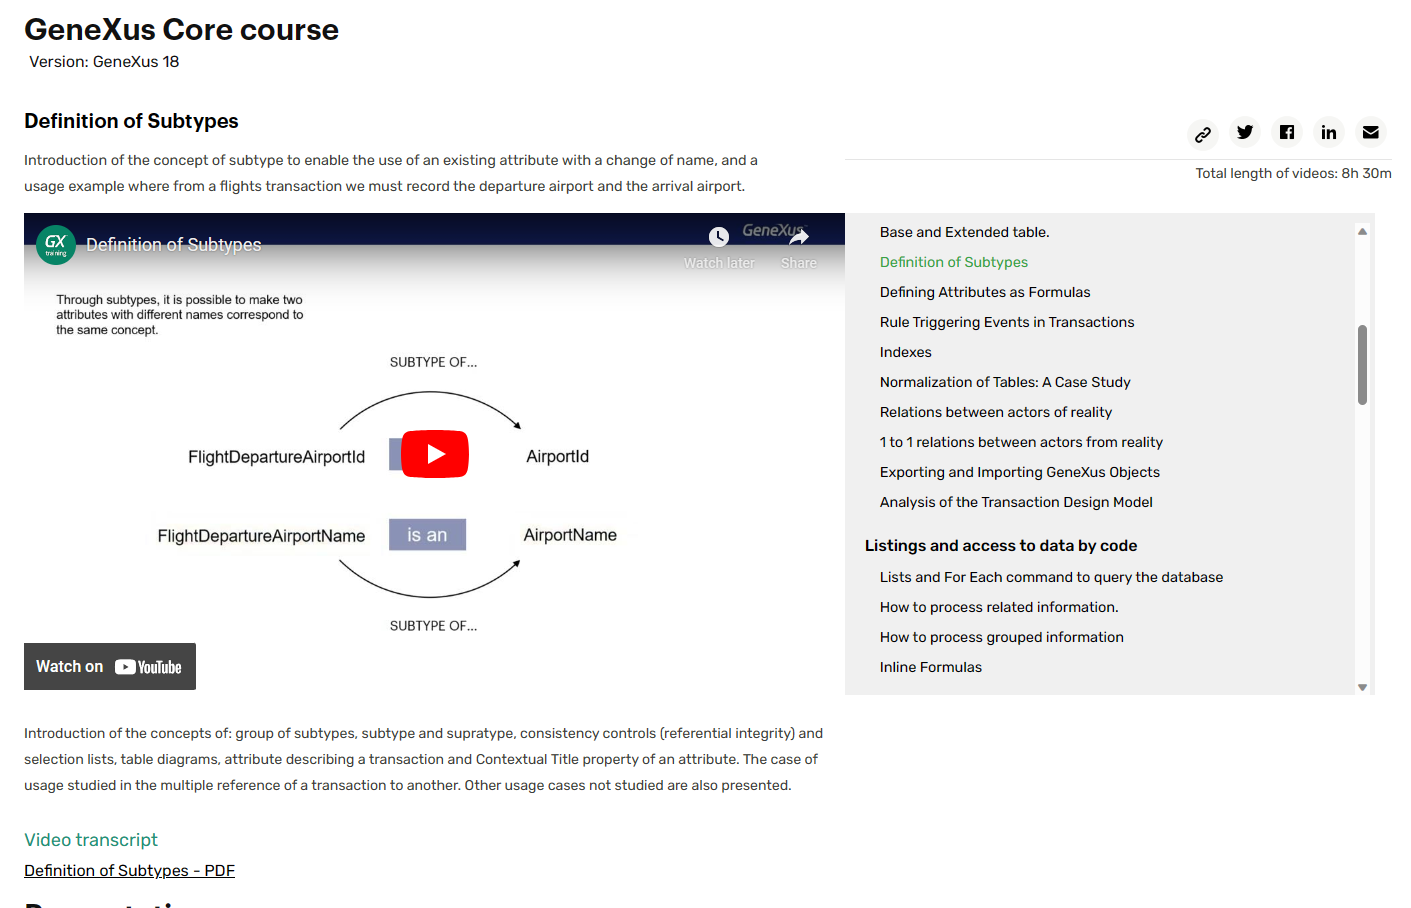

Puede notar que cada video o elemento del menú contiene una secció de particular interés, que es el acceso a la versión PDF de la clase. Por lo que basicamente, a continuación de cada elemento del menu de cada curso, se extrae dicho link al pdf de la clase, y se almacena en un diccionario.

In [ ]:
courses = {
    'Core': 'https://training.genexus.com/en/learning/courses/genexus/v18/core',
    'Extras Core': 'https://training.genexus.com/en/learning/courses/genexus/v18/core-extras-videos',
    'Production': 'https://training.genexus.com/en/learning/courses/genexus/v18/course-complementary-videos',
    'Advanced': 'https://training.genexus.com/en/learning/courses/genexus/v18/advanced',
    'Extras Advanced': 'https://training.genexus.com/en/learning/courses/genexus/v18/videos-extras-advanced',
    'Proficiency': 'https://training.genexus.com/en/learning/courses/genexus/v17/proficiency',
    'Extras Proficiency': 'https://training.genexus.com/en/learning/courses/genexus/v17/proficiency-extras-videos',
}

def find_pdf_link(url):
    try:
        # obtiene el link al pdf en el contenedor
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        script_div = soup.find('div', id='script')
        a_tag = script_div.find('a', href=True)
        pdf_link = a_tag.get('href').strip()
        return pdf_link
    except:
        return False

def find_links(title, url):
    # obtiene el contendor donde esta el link al pdf
    links = {}

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    ul = soup.find('ul', class_='categories')
    a_tags = ul.find_all('a')

    for a in tqdm(a_tags, desc=f'Processing {title}'):
        link_text = a.get_text().strip()
        href = a.get('href').strip()
        pdf_url = find_pdf_link(href)

        links[link_text] = [href, pdf_url]

    return links

all_courses = {}
for course, url in list(courses.items()):
    all_courses[course] = find_links(course, url)

Processing Extras Proficiency: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


In [ ]:
for course, content in all_courses.items():
    print(f"{course}: ")
    i = 1
    for title, urls in content.items():
        if i < 2:
            print(f"\t{title}: {urls[0]}\n\t\t{urls[1]}")
        elif i == 3:
            print(f'\t{len(content)-1} more...\n')
        i += 1

Core: 
	Digital applications today: https://training.genexus.com/en/learning/courses/genexus/v18/core/content/digital-applications-today-6104707
		https://training.genexus.com/en/learning/pdf/digital-applications-today-pdf-6104706
	47 more...

Extras Core: 
	Build process. Introduction: https://training.genexus.com/en/learning/courses/genexus/v18/core-extras-videos/content/build-process-introduction-6104933
		https://training.genexus.com/en/learning/pdf/build-process-introduction-pdf-6104932
	7 more...

Production: 
	UX Design. Introduction: https://training.genexus.com/en/learning/courses/genexus/v18/course-complementary-videos/content/ux-design-introduction
		https://training.genexus.com/en/learning/pdf/ux-design-introduction-pdf
	9 more...

Advanced: 
	Introducing GeneXus 18: The next-gen Software Development Platform: https://training.genexus.com/en/learning/courses/genexus/v18/advanced/content/introducing-genexus-18-the-next-gen-software-development-platform
		False
	56 more...

E

#### Directorio

Una vez obtenidos todos los links a los documentos, se almacenan los pdf descargados en un directorio local.

In [ ]:
def save_pdf(title, url):
    # crea el directorio
    dir_name = 'genexus_courses'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    # genera el archivo pdf
    if url:
        response = requests.get(url)
        filename = f"{title.replace(' ', '_')}.pdf"
        with open(os.path.join(dir_name, filename), 'wb') as f:
            f.write(response.content)

for course, content in all_courses.items():
    for title, urls in tqdm(content.items()):
        file_title = course + '_' + title
        save_pdf(file_title, urls[1])

100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


In [ ]:
# para ver cuantos pdf logro extraer
cwd = os.getcwd()
directory_path = os.path.join(cwd, "genexus_courses")

files = os.listdir(directory_path)
file_count = len(files)
print(file_count)

179


#### Texto

De un documento podemos extraer su contenido. Para facilitar la lectura se decide distingir del documento por página, y los parrafos que corresponden a dicha página.

In [ ]:
doc = fitz.open('/content/genexus_courses/Core_What_is_GeneXus?.pdf')

for page_number, page in enumerate(doc, start=1):
    words = page.get_text('blocks')

    # Filtro para no traer palabras o frases aisladas provenientes de footers o diagramas.
    filtered_words = [word[4].replace('\n', ' ') for word in words if len(word[4].split()) > 10]

    if filtered_words:
        print('Page number:', page_number)
        for filtered_word in filtered_words:
            print(limit_boundary(filtered_word, 12))
        print('\n\n')


Page number: 2
GeneXus is an intelligent platform that simplifies software development, automating everything that 
 can be automated.
It is LOW-CODE, which means that the least possible code is written, 
 most of it in a declarative way. Then, through artificial intelligence techniques 
 GeneXus
automatically generates source code, minimizing the times required for application development, evolution, 
 and maintenance.



Page number: 3
GeneXus allows building different types of applications, from the green screen ones 
 for Cobol or RPG systems, to state-of-the-art Web applications in Angular framework, 
 native code applications for mobile devices such as watches, cell phones, tablets 
 or Apple TV, as well as Artificial Intelligence applications, Chatbots, business process 
 modeling or the Internet of Things.



Page number: 4

application components for the different platforms where it is executed. For both 
 web and mobile applications, it generates the front-end (which runs on 

De esta forma podemos obtener nuevos documentos 'limpios' ordenados y solo con los textos relevantes para mantener nuestros documentos mas interpretables.

A continuación, de cada pdf se genera un archivo de texto plano con el formato anterior y se almacena para facilidad de acceso a estos documentos.

In [ ]:
input_directory = '/content/genexus_courses'
output_directory = '/content/cleaned_courses'
empty_files_count = 0

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for filename in tqdm(os.listdir(input_directory), desc="Processing PDFs", unit="file"):

    input_path = os.path.join(input_directory, filename)
    output_path = os.path.join(output_directory, f"{os.path.splitext(filename)[0]}.txt")

    doc = fitz.open(input_path)
    result_text = ""

    for page_number, page in enumerate(doc, start=1):
        # extrae el texto de cada pagina
        words = page.get_text('blocks')

        filtered_words = [word[4].replace('\n', ' ') for word in words if len(word[4].split()) > 10]

        if filtered_words:
            result_text += f'Page number: {page_number}\n'
            for filtered_word in filtered_words:
                result_text += limit_boundary(filtered_word, 12) + '\n'
            result_text += '\n\n'

        # guarda el docuemnto procesado como archivo de texto plano
        if result_text:
            with open(output_path, "w", encoding="utf-8") as txt_file:
                txt_file.write(result_text)

    if not result_text:
        empty_files_count += 1

print(f'\nArchivos vacios: {empty_files_count}')

Processing PDFs: 100%|██████████| 179/179 [00:07<00:00, 23.94file/s]


Archivos vacios: 66


Notar como no todos los pdfs han sido procesados. Esto se debe a que muchos de ellos contienen imagenes de texto, haciendo que no hata texto seleccionable en dichos documentos.

In [ ]:
!zip -r cleaned_courses.zip cleaned_courses/

updating: cleaned_courses/ (stored 0%)
updating: cleaned_courses/Production_UI_Customization._Introduction.txt (deflated 65%)
updating: cleaned_courses/Core_Web_panel_object._Loading_data_and_events.txt (deflated 66%)
updating: cleaned_courses/Advanced_Rules:_Review_and_Client_Side_Validation.txt (deflated 58%)
updating: cleaned_courses/Advanced_Horizontal_formulas.txt (deflated 65%)
updating: cleaned_courses/Core_Defining_Attributes_as_Formulas.txt (deflated 14%)
updating: cleaned_courses/Core_Creation_of_the_Knowledge_Base.txt (deflated 58%)
updating: cleaned_courses/Advanced_Evaluation_Tree_of_Triggering_of_Rules_and_Formulas.txt (deflated 64%)
updating: cleaned_courses/Advanced_Single-Level_Business_Components._Review.txt (deflated 63%)
updating: cleaned_courses/Core_What_is_GeneXus?.txt (deflated 59%)
updating: cleaned_courses/Advanced_Inserting_with_Procedure-Specific_Commands.txt (deflated 65%)
updating: cleaned_courses/Advanced_UI_Customization._Introduction.txt (deflated 65%)


### Grafos

Esta fuente no tiene el fin de nutrir con conocimiento técnico o especifico de la herramiento, sino brindar contexto para responder preguntas más genericas, de modo el modelo final pueda responder de manera informada con información extraida de una base de conociento en constante modificación.

##### WikiData

WikiData es una base de datos de grafos donde podemos consultar por información relacionada a una entidad. Es decir, de una entidad que exista en la base de conocimiento, se puede obtener sus objetos relacionados y como se relaccionan con ellos.

In [ ]:
API_ENDPOINT = "https://www.wikidata.org/w/api.php"

query = "GeneXus"

params = {
    'action': 'wbsearchentities',
    'format': 'json',
    'language': 'en',
    'search': query
}

response = requests.get(API_ENDPOINT, params=params)
data = response.json()

# extrae relaciones y metadata de la entidad 'GeneXus'
entity_id = data['search'][1]['id']
print(json.dumps(data['search'][1], indent=4))

{
    "id": "Q3100720",
    "title": "Q3100720",
    "pageid": 2963101,
    "display": {
        "label": {
            "value": "GeneXus",
            "language": "en"
        },
        "description": {
            "value": "Cross-Platform, knowledge representation-based development tool",
            "language": "en"
        }
    },
    "repository": "wikidata",
    "url": "//www.wikidata.org/wiki/Q3100720",
    "concepturi": "http://www.wikidata.org/entity/Q3100720",
    "label": "GeneXus",
    "description": "Cross-Platform, knowledge representation-based development tool",
    "match": {
        "type": "label",
        "language": "en",
        "text": "GeneXus"
    }
}


Las consultas a la base de datos de grafos se hace de forma particular mediante la sintaxis (SPARQL) demostrada debajo. La consulta de la función esta preparada para extraer todas las relaciones y tipos de relaciones de la entidad.

In [ ]:
def run_query(id):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    query = """
    SELECT ?wdLabel ?ooLabel
    WHERE {{
     VALUES (?s) {{(wd:{0})}}
     ?s ?wdt ?o .
     ?wd wikibase:directClaim ?wdt .
     ?wd rdfs:label ?wdLabel .
     OPTIONAL {{
     ?o rdfs:label ?oLabel .
     FILTER (lang(?oLabel) = "en")
     }}
     FILTER (lang(?wdLabel) = "en")
     BIND (COALESCE(?oLabel, ?o) AS ?ooLabel)
     }} ORDER BY xsd:integer(STRAFTER(STR(?wd), "http://www.wikidata.org/entity/P"))
    """.format(id)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results

# imprimir la lista de todas las relaciones
results = run_query(entity_id)
for result in results["results"]["bindings"]:
    print(result["wdLabel"]["value"], result["ooLabel"]["value"])

instance of programming language
instance of application framework
instance of declarative programming language
developer ARTech Consultores SRL
programmed in Prolog
inception 1988-01-01T00:00:00Z
Freebase ID /m/06vqgk
official website https://www.genexus.com
Quora topic ID GeneXus
programming paradigm declarative programming


##### Detección

Para poder extraer de las entidades sus relaciones e instancias es necesario identificar de que entidades extraer dichas relaciones. Por lo que se prepara el siguiente escenario para extraer de una consulta cualquiera las entidades principales de la misma.

In [ ]:
text = "Help me to buuild in Python a funtion that takes a string or sentence and return the most important entity in it, in order to use that entity as search paramenter in another function"

blob = TextBlob(text)
print(blob.noun_phrases)

['python', 'important entity', 'search paramenter']


De esta manera se puede consultar a WikiData sobre las relaciones de estas entidades principales

In [ ]:
def get_related_wikidata(user_query):
    blob = TextBlob(user_query)

    for noun in blob.noun_phrases:
        params = {
        'action': 'wbsearchentities',
        'format': 'json',
        'language': 'en',
        'search': noun
        }

        API_ENDPOINT = "https://www.wikidata.org/w/api.php"
        response = requests.get(API_ENDPOINT, params=params)
        data = response.json()

        entities_id = []
        for entity in data['search']:
            entities_id.append(entity['id'])

        text_content = ''
        text_content += f'{noun}:\n'
        try:
            resutl = run_query(entities_id[1])
            for r in resutl["results"]["bindings"]:
                text_content += f'\t{r["wdLabel"]["value"].strip()}: {r["ooLabel"]["value"]}\n'
            text_content += '\n'
        except:
            pass

        return text_content

print(get_related_wikidata('What was the reason for what Genexus born?'))

genexus:
	instance of: programming language
	instance of: application framework
	instance of: declarative programming language
	developer: ARTech Consultores SRL
	programmed in: Prolog
	inception: 1988-01-01T00:00:00Z
	Freebase ID: /m/06vqgk
	official website: https://www.genexus.com
	Quora topic ID: GeneXus
	programming paradigm: declarative programming




### Acceso rápido

Esta sección tiene intención de evitar todo el preprosamiento de los datos previos debido al tiempo que puede demorar esta actividad. Las siguientes celdas de código extraer los archivos comprimidos obtenidos y los trabaja directemente preprocesados.

#### Tabulares

El csv con los datos tabulares se encuentra en un directorio público que se puede acceder y recuperar aquí. Pero debe acceder a su cuenta de Google Drive para acceder al archivo.

In [ ]:
file_id = '1Y37pcJwlFM8V0QzmLD2cC7P40kPJEyD7'
!gdown --id $file_id

result_dataframe = pd.read_csv('genexus_wiki.csv')
result_dataframe = result_dataframe.loc[:, result_dataframe.columns != 'Unnamed: 0']
result_dataframe = result_dataframe.loc[:, result_dataframe.columns != 'Unnamed: 0.1']

print(result_dataframe.shape)
result_dataframe.head(1)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Y37pcJwlFM8V0QzmLD2cC7P40kPJEyD7
To: /content/genexus_wiki.csv
100% 8.85M/8.85M [00:00<00:00, 64.1MB/s]
(7952, 6)


,Source,Title,URL,Section,Content,Cleaned
0,Version 18,Total Experience,"https://wiki.genexus.com/commwiki/wiki?51570,T...",1,GeneXus 18 promotes Total Experience (https://...,genexus 18 promote total experience strategie...


#### Documentos

Puede descargar los archivos de textos plano preprocesados correspodientes a los cursos de Genexus mediante un comprimido de la carpeta.

In [ ]:
# por si ya existe el directorio
def delete_folder_contents_and_itself(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f'Successfully deleted the folder and all its contents: {folder_path}')
    else:
        print(f'The folder does not exist: {folder_path}')

folder_path = '/content/llamaindex_data'
delete_folder_contents_and_itself(folder_path)

The folder does not exist: /content/llamaindex_data


In [ ]:
# descargar el comprimido con los documentos
zip_file_id = '1OsguT9EmJmABasyKHsXXPwVM87Y4BdYy'
!gdown --id $zip_file_id

folder_name = 'llamaindex_data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OsguT9EmJmABasyKHsXXPwVM87Y4BdYy
To: /content/cleaned_courses.zip
100% 391k/391k [00:00<00:00, 124MB/s]


In [ ]:
# extraer del zip los documentos en la caperta llamaindex_data
def extract_zip_file(zip_file_path, extract_to='.'):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for member in zip_ref.namelist():
            filename = os.path.basename(member)
            if not filename:
                continue

            source = zip_ref.open(member)
            target = open(os.path.join(extract_to, filename), "wb")
            with source, target:
                shutil.copyfileobj(source, target)

zip_file_path = '/content/cleaned_courses.zip'
local_folder_name = 'llamaindex_data'

extract_zip_file(zip_file_path, local_folder_name)
os.remove(zip_file_path)

## Almacenamiento

Esta sección pretende contruir estructuras de datos que faciliten la comparación y busqueda semantica de texto en las diferentes fuentes con el fin de alimentar el contexto del modelo conversacional con información de utilidad.

### Base de Datos Vectorial

Para los datos tabulares utilizaremos una base de datos vectorial FAISS con el fin de almacenar en forma númerica los parrafos de las páginas de la Wiki de Genexus para su posterior recuperación en base a la cercania de los textos a ciertas oraciones de ingreso.

In [ ]:
# construccion de los documentos de texto
documents = []
for _, row in result_dataframe.iterrows():
    metadata = {'Source': row['Source'], 'Title': row['Title'], 'URL': row['URL'], 'Section': row['Section']}
    documents.append(Document(page_content=row['Cleaned'], metadata=metadata))

# embedding y almacenamiento
db = FAISS.from_documents(documents,
                          HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2'))

# configuracion de retorno
retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 3}
)

In [ ]:
# ejemplo
query = "What is the porpuse of the find formula?"
docs = db.similarity_search(query)

# para no traer mas de una vez el mismo texto si se repiten en mas de un pagina
seen_content = set()
for i in range(4):
    if docs[i].page_content not in seen_content:
        print(docs[i].page_content, '\n')
        seen_content.add(docs[i].page_content)

syntax find ( <aggregateexpression>, <aggregatecondition>, <defaultvalue>) [ <triggeringcondition> ]; where: <aggregateexpression>: expression whose resultant value return accord first record find match <aggregatecondition>. may contain attribute (even formula attributes), constants variables (user variables allow inline formulas ). <aggregatecondition>: combination search condition data selector  invocation. part optional: [<searchcondition>] [using <dataselector> '(' <parameter>1, <parameter>2, <parameter>n ')'] <searchcondition> condition record must verify consider aggregation. may contain attributes, constants variables (user variables allow inline formulas , genexus standard variables global formulas  inline formulas ). <defaultvalue> return value record match <aggregatecondition>. optional constant value accept (if formula use date attributes, see article too). <triggeringcondition> condition determine formula must trigger not. optional. attribute allow belong contextual table (

Notemos entonces como mediante una consulta en lenguaje natural, esta base de datos puede recuperar un top de los parrafos de texto mas cercanos o similares a la misma, recuperando no solo texto, sino tambien sintaxis y bloques de código.

In [ ]:
# para persistir los indices de la sb vectorial
db.save_local("faiss_index")

zipf = zipfile.ZipFile('faiss_index.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('/content/faiss_index/', zipf)
zipf.close()


# persistir los embeddings de la db
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(db.embeddings, f)

### Indices

Para los documentos se utiliza un enfoque dirente para realizar busquedas de textos similares a una consulta inicial. Para ello se utiliza un forma de generar nodos de texto que representan en espacios numericos multidimencionales los textos para ser buscados y comparados rapidamente.

In [ ]:
# para hacer embeddong de los documentos
embed_model = LangchainEmbedding(
    HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2'))

# tamanio fijo de cantidad de texto para convertir (256 = aprox, una pagina de un docuemnto)
text_splitter = SentenceSplitter(chunk_size=256)

# creacion de los indices
documents = SimpleDirectoryReader("llamaindex_data").load_data()
index = VectorStoreIndex.from_documents(documents, show_progress=True,
                                        service_context=ServiceContext.from_defaults(embed_model=embed_model,
                                                                                    text_splitter=text_splitter,
                                                                                     llm=None))

retriever = index.as_retriever(similarity_top_k=2)

LLM is explicitly disabled. Using MockLLM.


Parsing nodes:   0%|          | 0/113 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/456 [00:00<?, ?it/s]

De esta forma podemos consultar directamente a esta estructura por partes similares en nuestros documentos que puedan contener información relacionada.

In [ ]:
# ejemplo de uso
nodes = retriever.retrieve('find formula in data providers')
context_str = ''

for node in nodes:
    file_path = node.metadata["file_path"]
    pages = node.text

    print('\n--------\n')
    print(pages)


--------

Page number: 16
After this conceptual review of the use of formulas in GeneXus, we 
 can say they are very useful in many cases, and essentially provide 
 the following advantages:
- They allow us to save code, especially in the functionalities of 
 aggregate formulas that process many records. In turn, this frees us from 
 having to iterate on the records and implement the logic by code 
 to count, add, maximize, etc.
- They are a way to share knowledge, for example, in the 
 case of formula attributes that can be used in any object of 
 the knowledge base.
- Maintenance is centralized, since in the case of a global formula, 
 we change the definition in a single place—the transaction structure where the 
 attribute was defined.
- Defining formulas is even better than writing procedures and invoking them. 
 When a formula is defined, GeneXus is aware of its definition and 
 is able to generate optimized statements by combining the formula query with 
 the query in which the

In [ ]:
# para persistir los indices de la db
index.storage_context.persist("llama_indexes")
storage_context = StorageContext.from_defaults(persist_dir="llama_indexes")


zipf = zipfile.ZipFile('llama_indexes.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('/content/llama_indexes/', zipf)
zipf.close()

### Acceso Rápido

Las bases de datos de las fuentes tabulares y documentos pueden ser almacenadas como directorios persistentes. Esto con el fin de evitar regerear las bases de datos con cada inicio de programa. Las siguientes celdas descargan y preparan las bases y funciones necesarias para una ejecución rapida.

#### Funciones

In [ ]:
def limit_boundary(text: str, jump: int=20) -> str:
    '''Aniade saltos de linea cada cierta cantidad de caracteres para
       mejorar la visibilidad de la salida en la terminal'''

    words = text.split(' ')
    clean_words = []
    spaced_sentence = []

    # mantiene los saltos de lineas originales
    for w in words:
        patron = r'(\s+|\n)'
        resultado = re.split(patron, w)
        resultado = [palabra for palabra in resultado if (palabra!=' ' and palabra!='')]
        for w in resultado:
            clean_words.append(w)

    l_boundary = []  # Initialize l_boundary here

    # recorta iterativamente las longitudes y aniade saltos de linea en los limites
    while len(clean_words) >= jump:

        r_boundary = clean_words[:jump]
        l_boundary = clean_words[jump:]

        for w in r_boundary:
            spaced_sentence.append(w)
        spaced_sentence.append('\n')

        clean_words = l_boundary.copy()

    # incluye las palabras del final
    for w in l_boundary:
        spaced_sentence.append(w)

    return ' '.join(spaced_sentence)

In [ ]:
def clean_text(text):
    ''' Normalizar el texto '''
    text = text.lower() # normalizar en minisculas
    # text = text.translate(str.maketrans('', '', string.punctuation)) # eliminar signos de puntuacion (no rinde bien)
    text = ' '.join([word for word in text.split() if word not in stopwords]) # eliminar palabras de parada
    text = ' '.join([WordNetLemmatizer().lemmatize(word, pos="v") for word in text.split()]) # para llevar las palabras a su forma base
    text = re.sub(r'\(https://[^)]*\)', '', text) # remove URLs

    return text

In [ ]:
def zipdir(path, ziph):
    ''' descomprime los archivo zip en directorios '''
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file),
                       os.path.relpath(os.path.join(root, file),
                                       os.path.join(path, '..')))

#### Base de Datos Vectorial

In [ ]:
# descarga los indicies y los embeddings para reestablecer la base de datos vectorial
faiss_index_zip = '1aEzzuROJnyt7BOMRqwTxURD-cwu52eEf'
embeddings_faiss_pkl = '1wpnIqrzz1KXjx5Dv5kVD3UhkTT4j8kKo'
!gdown --id $faiss_index_zip
!gdown --id $embeddings_faiss_pkl

with zipfile.ZipFile('faiss_index.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

with open('faiss_embeddings.pkl', 'rb') as f:
    faiss_embeddings = pickle.load(f)


# recontruccion
db = FAISS.load_local("faiss_index", faiss_embeddings)

# elimina los comprimidos ya inecesarios
os.remove('faiss_index.zip')
os.remove('faiss_embeddings.pkl')

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aEzzuROJnyt7BOMRqwTxURD-cwu52eEf
To: /content/faiss_index.zip
100% 22.9M/22.9M [00:00<00:00, 64.7MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1wpnIqrzz1KXjx5Dv5kVD3UhkTT4j8kKo
From (redirected): https://drive.google.com/uc?id=1wpnIqrzz1KXjx5Dv5kVD3UhkTT4j8kKo&confirm=t&uuid=11e5cafa-8300-4f57-89be-64b86bd3603e
To: /content/faiss_embeddings.pkl
100% 439M/439M [00:05<00:00, 78.1MB/s]


#### Indices

In [ ]:
# descarga un comprimido con los indices de los documentos
llama_indixes_zip = '1Ohdy0D2jXUj8h3E5PeoI3n1lok-yQCGY'
!gdown --id $llama_indixes_zip

with zipfile.ZipFile('llama_indexes.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# reconstruccion del contexto
storage_context = StorageContext.from_defaults(persist_dir="/content/llama_indexes")

# modelos de procesamiento
embed_model = LangchainEmbedding(
    HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2'))

text_splitter = SentenceSplitter(chunk_size=256)


# recontruye los indices de los documentos
index = load_index_from_storage(storage_context, service_context=ServiceContext.from_defaults(embed_model=embed_model,
                                                                                    text_splitter=text_splitter,
                                                                                     llm=None))

retriever = index.as_retriever(similarity_top_k=2)

os.remove('llama_indexes.zip')

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ohdy0D2jXUj8h3E5PeoI3n1lok-yQCGY
To: /content/llama_indexes.zip
100% 19.3M/19.3M [00:00<00:00, 66.1MB/s]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

LLM is explicitly disabled. Using MockLLM.


#### Grafos

In [ ]:
# extrae todas las relaciones de un id de la base de conocimiento
def run_query(id):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    query = """
    SELECT ?wdLabel ?ooLabel
    WHERE {{
     VALUES (?s) {{(wd:{0})}}
     ?s ?wdt ?o .
     ?wd wikibase:directClaim ?wdt .
     ?wd rdfs:label ?wdLabel .
     OPTIONAL {{
     ?o rdfs:label ?oLabel .
     FILTER (lang(?oLabel) = "en")
     }}
     FILTER (lang(?wdLabel) = "en")
     BIND (COALESCE(?oLabel, ?o) AS ?ooLabel)
     }} ORDER BY xsd:integer(STRAFTER(STR(?wd), "http://www.wikidata.org/entity/P"))
    """.format(id)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results

# extrae las entidades del texto y las busca en la base
def get_related_wikidata(user_query):
    blob = TextBlob(user_query)

    for noun in blob.noun_phrases:
        params = {
        'action': 'wbsearchentities',
        'format': 'json',
        'language': 'en',
        'search': noun
        }

        API_ENDPOINT = "https://www.wikidata.org/w/api.php"
        response = requests.get(API_ENDPOINT, params=params)
        data = response.json()

        entities_id = []
        for entity in data['search']:
            entities_id.append(entity['id'])

        text_content = ''
        text_content += f'{noun}:\n'
        try:
            resutl = run_query(entities_id[1])
            for r in resutl["results"]["bindings"]:
                text_content += f'\t{r["wdLabel"]["value"].strip()}: {r["ooLabel"]["value"]}\n'
            text_content += '\n'
        except:
            pass

        return text_content

### Recuperadores

Podemos generalizar entonces la forma de extracción de los contenidos de forma simplificadas de esta forma.

In [ ]:
user_test_query = 'find function on Automatic data provider'
print('### INPUT ###')
print(user_test_query, '\n\n')




def get_tabulars(user_test_query):
    ''' Obtiene de la base de datos vectorial los contenidos similares '''
    context = ''
    seen_content = set() # para no repetir contenido

    for doc in db.similarity_search(user_test_query):
        # el contexto se forma por contenido, titulo y fuente del mismo

        if doc.page_content not in seen_content:
            source = doc.metadata['Source']
            title = doc.metadata['Title']
            seen_content.add(doc.page_content)
            context += f"Source: {source}, Title: {title}\nContent: {seen_content}\n"

    return context

print('### TABULARES ###')
print(get_tabulars(user_test_query))




def get_documents(user_test_query):
    ''' Obtiene de los indices de los documentos las paginas similares '''
    nodes = retriever.retrieve(user_test_query)
    context = ''

    for node in nodes[:1]:
        # se considera el contenido de la pagina y la ruta del archivo como contexto

        file_path = node.metadata["file_path"]
        context += f"file_path: {file_path}\n\n"
        context += f"{node.text}\n"

    return context

print('\n\n### DOCUMENTOS ###')
print(get_documents(user_test_query))




def get_graphs(user_test_query):
    ''' Obtiene de la base de conocimientos las relaciones de las entidades principales '''
    return get_related_wikidata(user_test_query)

print('\n\n### GRAFOS ###')
print(get_graphs(user_test_query))

### INPUT ###
find function on Automatic data provider 


### TABULARES ###
Source: General Development, Title: Find
Content: {"syntax find ( <aggregateexpression>, <aggregatecondition>, <defaultvalue>) [ <triggeringcondition> ]; where: <aggregateexpression>: expression whose resultant value return accord first record find match <aggregatecondition>. may contain attribute (even formula attributes), constants variables (user variables allow inline formulas ). <aggregatecondition>: combination search condition data selector  invocation. part optional: [<searchcondition>] [using <dataselector> '(' <parameter>1, <parameter>2, <parameter>n ')'] <searchcondition> condition record must verify consider aggregation. may contain attributes, constants variables (user variables allow inline formulas , genexus standard variables global formulas  inline formulas ). <defaultvalue> return value record match <aggregatecondition>. optional constant value accept (if formula use date attributes, see artic

Hasta aqui se consigue poder obtner información de contexto para las preguntas de las diferentes fuentes con simpleas llamadas a funciones.

## Modelo de clasificación

El modelo de clasificación tiene la inteción de que determine la complejidad de la pregunta del usuario, con el fin de no recuperar información cercana a la misma de todas las fuentes a la vez, si no solo de una acorde a su contenido.

Recordemos:
- Relaciones de WikiData: corresponde a preguntas genericas
- Páginas de la Wiki: corresponde a preguntas de dificultad media
- Documentos de los cursos: corresponde a preguntas mas complejas

### Clasificación

Se requiere una forma de clasificar las preguntas con el fin de buscar en las diferentes fuentes la información de contexto que corresponda. Pero como cada fuente tiene un proposito en particular, podemos determinar tres categorias de preguntas, donde se usara un fuenta de datos para cada clase de pregunta.

Para ello se utiliza un modelo de lenguaje que nos ayudara a clasificar la consulta del usuario en tres categorias dependiendo de la complejidad de la misma.

In [9]:
# llamada al modelo mediante api
hg_api_key = userdata.get('hg_api_key')
API_URL = "https://api-inference.huggingface.co/models/HuggingFaceH4/zephyr-7b-beta"
headers = {"Authorization": f"Bearer {hg_api_key}"}

# envia la consulta al servidor y responde
def send_query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

In [10]:
# le enseñamos al modelo a que categoria corresponden los ejemplos.
# de esta manera sabra dependiendo de la pregunta, que clase debe retornar

def build_clasification_instruction(user_query):
    quest_to_model = f""" <|system|>
    You are a query classifier that does not response queries, but only classify queries on these categories:
    0 - general knowledge (Generic questions about GeneXus or other things)
    1 - rules, funcions and sysntax (Basic definitions in GeneXus to develop logic and object)
    2 - development and techniques (Integration among external technologies, and high level methodologies)
    <|user|>
    +"What is the programming paradigm of Genexus?"</s>
    <|assistant|>
    0</s>
    <|user|>
    +"Talk me about the main goal of the company"</s>
    <|assistant|>
    0</s>
    <|user|>
    +"What are common advices to write clean code in general?"</s>
    <|assistant|>
    0</s>
    <|user|>
    +"Explain me the best good practices to write clean code in Genexus"</s>
    <|assistant|>
    0</s>
    <|user|>
    +"How can I trigger the event after commit the data?"</s>
    <|assistant|>
    1</s>
    <|user|>
    +"Explain me the use of each parameter in the Msg function"</s>
    <|assistant|>
    1</s>
    <|user|>
    +"How can I declare in the Parm rule a parameter that can be input and output at the same time?"</s>
    <|assistant|>
    1</s>
    <|user|>
    +"How can i build the find formula that find the CategoryId corresponding to the name "Classic" for CategoryName attribute with a condition  that CategoryActive is True?"</s>
    <|assistant|>
    1</s>
    |user|>
    +"How can I automate my devops enviroment in order different sources commited to server can be merged automatically using Jenkins?"</s>
    <|assistant|>
    2</s>
    <|user|>
    +"I have a Dynamic combo box that must contain a string values from a transaction, but the string is larger than the space in the combo. How must be defined the style class in order the combo space become larger than default?"</s>
    <|assistant|>
    2</s>
    <|user|>
    +"I have a screen where to grids must be inserted and operate above certain logic that affect to both. There is some way i can build a syncronized logic for both grids simulstaneously?"</s>
    <|assistant|>
    2</s>
    <|user|>
    +"Teach me how to intregrate a remote github repository in my KB"</s>
    <|assistant|>
    2</s>
    <|user|>
    +"{user_query}"</s>
    <|assistant|>
    """
    return quest_to_model

clasification_instruction = build_clasification_instruction
max_tokens_classification = 1  # forzamos a que solo responda con el numero de la clase

Podemos armar una función general que que tome como parametro una función que determina la instrución para el modelo. De esta forma mediante una sola función podemos obtener una repuesta del modelo con una sola llamada.

In [11]:
# envia la estrutura de la intrucion al servicio
def get_output(instruction, max_tokens=256):
    output = send_query({
        "inputs": instruction,
        "parameters": {
            "do_sample": True,
            "max_new_tokens": max_tokens,
            "return_full_text": False
        }
    })

    try:
        return output[0]['generated_text'].strip() # solo el texto generado
    except:
        return output # en caso de que el modelo no se pueda usar

user_query = 'What is the most recommend way to write efficent and cleaned programas?'
print(get_output(clasification_instruction(user_query), max_tokens_classification))

0


Notemos como esta llamada retorna solamente el numero que representa la clase de la consulta. En este caso, de conocimiento general, tal como se espera.

### Agente de desición

Una vez obtenida la clase a la que pertenece la consulta, podemos obtener la información de contexto similar a la misma desde la fuente establecida.

In [ ]:
# dependiendo como el modelo clasifique la consulta, retorna un texto desde la fuente apropiada
def retrive_from_source(user_query):

    # obtiene la clase de la consulta
    query_class = get_output(clasification_instruction(user_query), max_tokens_classification)

    # valida que el formato sea valido
    if isinstance(query_class, dict):
        query_class = 0
    elif (query_class == False) or (not int(query_class)):
        query_class = 0
    query_class_int = int(query_class)

    context = ''

    # obtiene desde la fuente apropiada
    if query_class_int == 0:
        response = get_graphs(user_query)
        if response is not None:
            context = response
        else:
            context = 'No se encontraron entidades.'
    elif query_class_int == 1:
        context = get_tabulars(user_query)
    elif query_class_int == 2:
        context = get_documents(user_query)

    return context

print(retrive_from_source('What is the permission prefix property in most of genexus objects?'))

Source: Genexus Server, Title: KB Security Defaults
Content: {'genexus server kb security default subnode security node  list group users knowledge base permissions. elements list vary depend whether tab select group users tab. element group tab show group name knowledge base permissions. hand, element users tab show username, authentication type, knowledge base permissions.'}
Source: Genexus Server, Title: Groups and Users Permissions
Content: {'server permissions every group user set define permissions (potentially empty) relate administration server instance itself. permissions predefined genexus server instance: publish allow send knowledge base genexus server instance. note: user, send knowledge base genexus server full control it. manage security allow manage permissions group users genexus server instance. also, manage genexus server license. please refer genexus server security information. manage user control allow instal uninstalling user control genexus server instance. plea

Los siguiente son casos de prueba de cada clase para validar que clasifica de la forma esperada, y genera el contenxto de la fuente de datos adecuada a la clase con texto similar a la consulta.

In [ ]:
queries = ['Tell me about the parameters the find formula accept',
           'how to automate your Calendar to save time',
           'Design the arquitecture of an application that runs throug microservices and orquested by containered programs running in a cloud server',
           ]

for query in queries:
    context = retrive_from_source(query)
    print(f'{context}\n')

Source: Genexus Access Manager, Title: LDAP
Content: {'#2 parameters'}
Source: General Development, Title: Find
Content: {'#2 parameters', "syntax find ( <aggregateexpression>, <aggregatecondition>, <defaultvalue>) [ <triggeringcondition> ]; where: <aggregateexpression>: expression whose resultant value return accord first record find match <aggregatecondition>. may contain attribute (even formula attributes), constants variables (user variables allow inline formulas ). <aggregatecondition>: combination search condition data selector  invocation. part optional: [<searchcondition>] [using <dataselector> '(' <parameter>1, <parameter>2, <parameter>n ')'] <searchcondition> condition record must verify consider aggregation. may contain attributes, constants variables (user variables allow inline formulas , genexus standard variables global formulas  inline formulas ). <defaultvalue> return value record match <aggregatecondition>. optional constant value accept (if formula use date attribute

Notamos como ha detectado correctamente la clase a la que pertenece cada pregunta y retornado el contexto similar de forma esperada.

## Modelo de Lenguaje

El modelo de lenguaje es aquel que será utilizado para mantener una conversación con el usuario, obteniendo respuestas apropiadas y adaptadas a los ingresos. EL mismo es capaz de mantener una conversión coherente con el usuario en español.

### Elección de modelo

En la instancia anterior hemos definido funciones que son de utilidad para enviar consultas y obtener respuestas mediante API al modelo Zephyr. Este mismo mecánismo será utilizado para el modelo conversacional.

Por lo que definimos el constructor de como el modelo interpretará la instrucción basada en el contexto extraido de las fuentes configuradas.

In [ ]:
def build_role_context_instruction(user_query, bot_role, context):
    quest_to_model = f""" <|system|>
    {bot_role}
    </s>
    <|user|>
    Context: {context}
    Question: {user_query}</s>
    <|assistant|> """

    return quest_to_model

context_instruction = build_role_context_instruction
max_tokens_conversation = 320

assitant_role = 'You are an assitant with a lot a knowledge about GeneXus development that response using only the provided context'
user_query = 'Define the find formula that assign the CategoryId corresponding to the name "Classic" for CategoryName attribute'
context_test = retrive_from_source(user_query)

In [ ]:
print('Query:\n', user_query)

print('\nContext:\n', context_test)

print('\nModel:\n', get_output(context_instruction(user_query, assitant_role, context_test), max_tokens_conversation))

Query:
 Define the find formula that assign the CategoryId corresponding to the name "Classic" for CategoryName attribute

Context:
 Source: General Development, Title: Find
Content: {"syntax find ( <aggregateexpression>, <aggregatecondition>, <defaultvalue>) [ <triggeringcondition> ]; where: <aggregateexpression>: expression whose resultant value return accord first record find match <aggregatecondition>. may contain attribute (even formula attributes), constants variables (user variables allow inline formulas ). <aggregatecondition>: combination search condition data selector  invocation. part optional: [<searchcondition>] [using <dataselector> '(' <parameter>1, <parameter>2, <parameter>n ')'] <searchcondition> condition record must verify consider aggregation. may contain attributes, constants variables (user variables allow inline formulas , genexus standard variables global formulas  inline formulas ). <defaultvalue> return value record match <aggregatecondition>. optional constan

Notamos como ha podido clasificar correctamente la pregunta para la categoria de funciones, reglas y sintaxis, obtiendo de la fuente tabular la sintaxis de la funcion por la que se consulta. El modelo responde de manera esperada ante este contexto y a la cosulta.

### Contexto

Un contexto voluminoso para un modelo puede no resultar benefisioso. La idea es separar los documentos cernanos en partes, y quedarse con las partes particulares de estos documentos que mas se parezcan a la pregunta inicial del usuario.

In [ ]:
def split_text_in_parts(context):
    ''' Separa en segmentos fijos el texto de contexto '''
    splitter = SentenceSplitter(chunk_size=200)
    return splitter.split_text(context)


context = retrive_from_source('talk me about the inout arguments in objects')

for sentence in split_text_in_parts(context):
    print(limit_boundary(sentence, 12), '\n---\n')

Source: General Development, Title: Knowledge Base Documentation 
 Content: {'see also object 
 documentation '} 
 Source: Mobile Apps, Title: External Objects for Native Mobile 
 Applications 
 Content: {'see also object documentation ', 'considerations inout parameters supported, 
 parameters consider in. return one value, use sdt object.'} 
 Source: General 
 Development, Title: Parm 
 Content: {'see also object documentation ', 'considerations inout 
 parameters supported, parameters consider in. return one value, use sdt object.', 'syntax 
 parm([in:|out:|inout:]parm1, …, [in:|out:|inout:] parmn); where: in: | out: | inout: operators allow 
 define parameter, go use call object (in, out, inout ). parm1, ..., 
 parmn: variables attribute define call object. parameter received, decide whether declare attribute 
 variable, regardless sent.'} 
---

Source: General Development, Title: Knowledge Base Documentation 
 Content: {'see also object 
 documentation '} 
 Source: Mobile Apps, Ti

Para determinar cuales son las partes de los documentos mas cercanas al contexto de la pregunta, se llevan tanto las oraciones como la pregunta a un espacio vectorial que permitira determinar que tan cercanas son las oraciones de la pregunta, y con ello podemos quedarnos con un top de las mejores oraciones para utilizar como contexto.

In [ ]:
def embed_text(context, is_query=False, model=embed_model):
    # se vectorizan el texto con el modelo definido en el entorno
    embeddings_sentences = []

    # se diferencia en vectorizar una lista de textos o solo un texto
    if not is_query:
        for sentence in context:
            sentence_embeddings = embed_model.get_text_embedding(sentence)
            embeddings_sentences.append(sentence_embeddings)
    else:
        embeddings_sentences.append(embed_model.get_query_embedding(context))

    return embeddings_sentences


def get_most_relevant_content(content, query:str, is_list=False):
    ''' De una lista de textos y la consulta del usuario, se compara en un espacio
        vectorial la cercania de cada parte del texto con la consulta, y retorna
        solo la parte del texto mas cercana '''

    if not is_list:
        # separar en partes el contenido
        tokens_sentences = split_text_in_parts(content)
    else:
        tokens_sentences = content

    # obtiene las representaciones numericas de los textos con tensores
    context_embeddings = torch.tensor(embed_text(tokens_sentences, False))
    query_embed = torch.tensor(embed_text(query, True))

    # se obtiene la distancia de coseno entre la pregunta y cada oracion
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    puntuaciones_coseno = cos(context_embeddings, query_embed)
    indices_ordenados = torch.argsort(puntuaciones_coseno, descending=True)

    # retornar solo el mas cercano
    return tokens_sentences[indices_ordenados[0]]

print(limit_boundary(get_most_relevant_content(context, user_query), 10))

return one value, use sdt object.'} 
 Source: General Development, 
 Title: Parm 
 Content: {'see also object documentation ', 'considerations 
 inout parameters supported, parameters consider in. return one value, use 
 sdt object.', 'syntax parm([in:|out:|inout:]parm1, …, [in:|out:|inout:] parmn); where: in: | 
 out: | inout: operators allow define parameter, go use call 
 object (in, out, inout ). parm1, ..., parmn: variables attribute 
 define call object. parameter received, decide whether declare attribute variable, 
 regardless sent.'} 
 Source: General Development, Title: In For Each 
 groups 
 Content: {"2. 'in' operator clause", 'see also object 
 documentation ', 'considerations inout parameters supported, parameters consider in. return 
 one value, use sdt object.', 'syntax parm([in:|out:|inout:]parm1, …, [in:|out:|inout:] parmn); 
 where: in: | out: | inout: operators allow define parameter, 
 go use call object (in, out, inout ).


### Memoria

La idea es que el modelo pueda mantener la coherencia de la conversación respecto a las consultas y respuestas previas. Por ellos se persisten dos memorias. Una para las respuestas que el modelo genera a lo largo de la conversación, y otra para las preguntas del usuario.

In [ ]:
model_responses_history = []
user_queries_history = []

Esto con el fin de que el modelo pueda reconocer del contexto cosas que ya ha dicho el mismo o el usuario previamente.

In [ ]:
def save_in_context_memory(content, is_model=True):
    ''' Guardar en memoria de la conversiacion las preguntas y repuestas '''
    global model_responses_history
    global user_queries_history

    if is_model:
        if content not in model_responses_history:
            model_responses_history.append(content)

    else:
        if content not in user_queries_history:
            user_queries_history.append(content)

In [ ]:
# pruebas

user_query = 'Which arguments is firts  in the find formula?'
save_in_context_memory(user_query, is_model=False)

user_query = 'Define the find formula that assign the CategoryId corresponding to the name "Classic" for CategoryName attribute'
save_in_context_memory(user_query, is_model=False)

print(user_queries_history)

['Which arguments is firts  in the find formula?', 'Define the find formula that assign the CategoryId corresponding to the name "Classic" for CategoryName attribute']


Como el tamano del contexto es limitado, no consideramos todo el historial de la conversación como contexto del modelo, sino solo las preguntas y respuestas mas relevantes de la conversación para la consulta de la iteración actual.

In [ ]:
def get_from_context(user_query):
    ''' obtiene de los historiales las preguntas y repuestas mas cernanas a la pregunta actual '''

    global model_responses_history
    global user_queries_history

    # pregunta del historial mas cercana a la actual
    try:
        user_relevant = get_most_relevant_content(user_queries_history, user_query, is_list=True)
    except IndexError: # en caso de la primera iteracion donde la memoria esta vacia
        user_relevant = ' '

    # respuesta del historial mas cercana a la pregunta actual
    try:
        model_relevant = get_most_relevant_content(model_responses_history, user_query, is_list=True)
    except IndexError:
        model_relevant = ' '

    return model_relevant, user_relevant

get_from_context('How must be writed the condition in the argument?')

(' ', 'Which arguments is firts  in the find formula?')

### Autocompletado

Muchas veces el modelo de lenguaje esta limitado por la cantidad de tokens que puede generar. Esto da lugar a inconsistencias donde genera textos que no tiene un final coherente por la generación de la respuesta se corta abruptamente.

Para darle al usuario la sensación de respuestas completas en todo momento, se genera una técnica de autocompletado de la respuesta del modelo para terminar de formar la oración o parrafo.

In [ ]:
def is_sentence_complete(content):
    ''' Para detectar cuando una oracion esta completa '''
    is_complete = True

    # no es completa si esta vacia
    if len(content) == 0:
        is_complete = False
    # no es completa si termina con un punto pero corresponde a una lista de nuemeros (cuando explica en paso 1., 2., etc.)
    elif re.search(r'\n\d+\.$', content):
        is_complete = False
    # no es completa si no es una palabra seguida de un signo de puntacion apropiado
    elif not re.search(r'[a-zA-Z][.!?]$', content):
        is_complete = False

    return is_complete

En caso de detectar que un texto no esta completo, se le pide en otra ocación nuevamente al modelo de lenguaje que genere un breve texto para concatenar al texto incompleto que le de cierre al texto final.

In [ ]:
# le enseñamos al model a completar brevemente lso texto incompletos
def build_completion_instruction(incomplete_text):
    text_to_model = f"""<|system|>
    You are a language model that completes the given incomplete text with few words as possible. You should not regenerate the entire text, but only generate the missing part to make the text complete.
    <|user|>
    By moving to the cloud, businesses can reduce their energy consumption and carbon footprint by up to 90%. Rather than having in-house servers and software, businesses can use cloud-based services to access the same applications</s>
    <|assistant|>
    and data from any computer.</s>
    <|user|>
    Inheritance is one of the core features of object-oriented programming. It’s a programming procedure that allows you to reuse code by referencing the behaviors and data of an object. In other words, a class that inherits from another class shares</s>
    <|assistant|>
    all the attributes and methods of the referenced class.</s>
    <|user|>
    An API object groups several services that are semantically and functionally related. For each service, it declares a mapping between its external name (exposed as a service) and the internal implementation in the KB. It features flexibility in terms of service declaration, allowing the configuration of the HTTP method</s>
    <|assistant|>
    to be used when the service is REST.</s>
    <|user|>
    GeneXus is the most comprehensive provider of artificial intelligence tools for software development that is currently redefining the digital era and assisting companies in overcoming all challenges and interruptions caused by new</s>
    <|assistant|>
    technology and business needs.</s>
    <|user|>
    {incomplete_text}</s>
    <|assistant|>
    """
    return text_to_model

completion_instruction = build_completion_instruction
max_tokens_completion = 32  # forzamos que genere pacas palabras para finalizar el texto

In [ ]:
# Ejemplo

context_test = '''The formula knows to return the CategotyId values as a result because it is defined in the syntax for the
 FIND function, specifically in the <defaultvalue> section. When using the FIND function with an aggregate formula, you can optionally provide
 a default value to return if the search condition is not met. In this case, you are using the FIND
 function to find the first record that meets a certain condition (defining a CategotyId) for'''

if not is_sentence_complete(context_test):
    print(limit_boundary(get_output(completion_instruction(context_test), max_tokens_completion), 16))

a specific Company and Product. Since this formula is used in the Sum() function to calculate 
 the revenue, the CategotyId value is essentially acting as


Notamos que sigue sin completar correctamente el final del texto en ocaciones. Pero que si finalizo con una parte. Por lo que se plantea, que si en dos iteraciones de autocompletado el texto sigue siendo incompleto, entonces remover el texto desde el ultimo punto en adelante, con el fin de que el texto llege hasta el punto que da fin a la ultima oración del texto.

In [ ]:
def automatic_autocompletation(content, max_tokens_completion=32):
    ''' Si luego de dos iteraciones de autocompletar un texto sigue incosistene, recorta el texto hasta volverlo completo '''
    completed =  ''
    iteration = 1

    try:
        completed += content

        # realiza dos iteraciones de completar el texto
        while not is_sentence_complete(completed) and iteration <= 2:
            iteration += 1
            output = get_output(completion_instruction(completed), max_tokens_completion)
            if isinstance(output, dict):
                break
            completed += ' ' + output

        # el sigue siendo incompleto, elimina recorusivamente desde atras hacia adelante hasta que sea consistente
        previous_length = len(completed)
        while not is_sentence_complete(completed):
            completed = re.sub(r'[^.]*$', '', completed)
            if len(completed) == previous_length:
                break
            previous_length = len(completed)

    except:
        completed = ''

    return completed

In [ ]:
# ejemplo
completed_content = automatic_autocompletation('''To filter by variable values in a grid that has attributes of a transaction if the variables
                                                 correspond to that transaction, you can use GeneXus\' built-in Filter by Variable feature.
                                                 Here\'s how:\n\n1. Open the transaction in GeneXus IDE and move to the grid that contains the
                                                 attributes you want to filter.\n2. Click on the grid\'s properties (F4) and go to the Filter tab.\n3.
                                                 Click on the "Add" button to define a new filter.\n4. In the Filter Properties dialog box,
                                                 give the filter a name and choose your variable from the list of available variables.
                                                  You can use the wildcard characters (* and ? ) in the variable name to make''', max_tokens_completion=14)
print(limit_boundary(completed_content))

To filter by variable values in a grid that has attributes of a transaction if the variables 
 correspond to 
 that transaction, you can use GeneXus' built-in Filter by Variable feature. 
 Here's how: 

 1. Open the transaction in 
 GeneXus IDE and move to the grid that contains the 
 attributes you want to filter. 
 2. Click on 
 the grid's properties (F4) and go to the Filter tab. 
 3. 
 Click on the "Add" button to define 
 a new filter. 
 4. In the Filter Properties dialog box, 
 give the filter a name and choose your 
 variable from the list of available variables. 
 You can use the wildcard characters (* and ? ) in the 
 variable name to make your filter more specific.


Notemos como paso de dejar un texto con final incompleto a generar una pocas palabras mas para darle fin consistente.

### Traducción

Debido a que la documentación de Genexus está en inglés y no se puede obtener directamente en español, se opta por añadir un paso más a la hora de interactuar, que es la traducción automática del texto tanto ingresado como retornado, debido a en la interfaz el usuario debe poder conversar en español, pero el modelo de fondo trabaja en inglés.

In [ ]:
# ejemplo de uso de traductor
rol_en = GoogleTranslator(source='es', target='en').translate("Eres un programador experto Genexus que siempre responde utilizando el contexto proporcionado.")
print(rol_en)

rol_es = GoogleTranslator(source='en', target='es').translate("You are an Genexus expert programer that always responds using the provided context.")
print(rol_es)

You are an expert Genexus programmer who always responds using the context provided.
Eres un programador experto Genexus que siempre responde utilizando el contexto proporcionado.


Un problema que se presenta es que el código no debe ser traducido ya que usa palabras reservadas del lenguaje. Para ello se crea la siguiente función para evitar la traducción en bloques de texto.

In [ ]:
# Expresión regular para identificar patrones especiales en el texto
code_block_pattern = re.compile(r'`{3}.*?`{3}', re.DOTALL)
code_line_pattern = re.compile(r'`{1}.*?`{1}', re.DOTALL)
quotes_pattern = re.compile(r'"{1}.*?"{1}', re.DOTALL)


def translate_text(text, source, target):
    '''Traducir al español la respuesta, excluyendo bloques de código,
       palabras compuestas y referencias'''
    # Encuentra todos los bloques de código en el texto
    code_blocks = code_block_pattern.findall(text)
    code_line = code_line_pattern.findall(text)
    quotes = quotes_pattern.findall(text)

    # Reemplaza los patrones con marcadores temporales
    for i, block in enumerate(code_blocks):
        text = text.replace(block, f'__CODE_BLOCK_{i}__')
    for i, block in enumerate(quotes):
        text = text.replace(block, f'__QUOTE_{i}__')
    for i, block in enumerate(code_line):
        text = text.replace(block, f'__COMPOSED_{i}__')

    # Traduce el texto sin los bloques de código
    translated_text = GoogleTranslator(source=source, target=target).translate(text)

    # Restaura los bloques en la traducción
    for i, block in enumerate(code_blocks):
        translated_text = translated_text.replace(f'__CODE_BLOCK_{i}__', block)
    for i, block in enumerate(quotes):
        translated_text = translated_text.replace(f'__QUOTE_{i}__', block)
    for i, block in enumerate(code_line):
        translated_text = translated_text.replace(f'__COMPOSED_{i}__', block)

    return translated_text

In [ ]:
# ejemplo de uso
example_with_code = '''
3. In the details view, click the "Formula" tab to open the formula editor.
4. Click the "New Formula" button to create a new formula.
5. In the formula editor, enter the following formula:
```
Sum(Price, Where(Level = Level - 1))
```
6. Save the formula and close the formula editor.
7. Open the Entity-Diagram where you defined the global formula...'''

model_answer_es = translate_text(example_with_code, 'en', 'es')
print(model_answer_es)

3. En la vista de detalles, haga clic en la pestaña "Formula" para abrir el editor de fórmulas.
4. Haga clic en el botón "New Formula" para crear una nueva fórmula.
5. En el editor de fórmulas, ingrese la siguiente fórmula:
```
Sum(Price, Where(Level = Level - 1))
```
6. Guarde la fórmula y cierre el editor de fórmulas.
7. Abra el diagrama de entidad donde definió la fórmula global...


Notamos como la traducción es acertada y que los bloques de código ni las palabras referenciadas permanecen en el idioma original como se espera.

### Complementación

La idea es que una unica llamada al modelo con una pregunta pueda resolver toda la lógica asociada en encontrar el contexto adecuado, y recibir la respuesta esperada en la salida. En otras palabras, se debe armar un circuito de llamadas que haga uso de todas las funcionalidades por dentro desde una simple pregunta del usuario.

In [ ]:
# incializo la memoria vacia
model_responses_history = []
user_queries_history = []

def query_to_model(user_query, assitant_role, max_tokens_conversation=256, max_tokens_completion=32):
    '''enviar consulta al modelo, clasifica la misma y obtiene de las fuentes
        apropiadas las partes mas relevantes. Genera un contexto formado por las fuentes,
        y el historial de conversacion. Y genera una repuestas traducida. Guarda en el
        historial las generaciones.'''

    global model_responses_history
    global user_queries_history

    # traduce al ingles la pregunta del usuario para usar en busquedas
    user_query_en = translate_text(user_query, 'es', 'en')

    # obtiene la informacion de contexto desde las fuentes y desde el historial
    source_context = retrive_from_source(user_query_en)
    relevant_source_context = get_most_relevant_content(source_context, user_query_en)
    relevant_from_model, relevant_from_user = get_from_context(user_query_en)

    # formato del contexto para que Zhepyr interprete los origines
    final_context = 'This is the associated documentation:\n' + relevant_source_context + '\n\n'
    final_context += 'This is a related response in the conversation:\n' +  relevant_from_model + '\n\n'
    final_context += 'And this is a related query in the conversation:\n' +  relevant_from_user

    # obtine respuesta del modelo y asegura su completitud
    model_response = get_output(context_instruction(user_query_en, assitant_role, final_context), max_tokens=max_tokens_conversation)
    completed_content = automatic_autocompletation(model_response, max_tokens_completion=max_tokens_completion)

    # traduce la respuesta al español
    model_answer_es = translate_text(completed_content, 'en', 'es')

    # guarda en memoria la pregunta y respuesta en ingles
    save_in_context_memory(user_query_en, is_model=False)
    save_in_context_memory(completed_content, is_model=True)

    return model_answer_es

Probemos una ejemplo de conversación para analizar como se comporta el modelo y la memoria de la conversación.

In [ ]:
assitant_role = 'You are an assitant with knowledge about GeneXus development that use the provided context and GeneXus code syntax between triple backticks. If the context does not match with the query, use your own knowledge, otherwise, use only the provided context. Your responses must be simple, direct and short.'
user_query = 'Dime como armar una formula en la cabecera de la transaccion que obtiene la suma de los valores del campo ProductPrice del subnivel, pero solo sumando el precio de aquellos productos que son CategoryName="Classic"'

print(limit_boundary(query_to_model(user_query, assitant_role)))

Para crear una fórmula en el encabezado de la transacción que obtenga la suma del campo ProductPrice del subnivel, pero 
 solo sumando el precio de aquellos productos que sean CategoryName="Classic", sigue estos pasos: 

 1. Abra la transacción en modo 
 de edición. 
 2. Haga clic en el botón de edición del encabezado. 
 3. Agregue una nueva fórmula usando 
 el botón "+" en el Editor de fórmulas. 
 4. Asigne un nombre a la fórmula (por ejemplo, "ClassicProductPriceTotal"). 
 
 5. En el editor de fórmulas, cree una fórmula horizontal usando "Horizontal Formula Builder" (HPB). 
 6. Agregue una condición 
 para filtrar por Nombre de categoría: 

 ```gxsharp 
 iif(categoryname="Classic",productprice,"") 
 ``` 

 7. Conecte la salida de condición a 
 la operación de suma en HPB: 

 ```gxsharp 
 SUM(iif(categoryname="Classic",productprice,""))) 
 ``` 

 8. Cierre el editor de fórmulas y 
 guarde los cambios. 

 Ahora tendrá un nuevo campo de encabezado con el valor calculado para la fórmula 

In [ ]:
user_query = 'Como es que la formula "iif" filtra por las categorias correspondientes?'

print(limit_boundary(query_to_model(user_query, assitant_role)))

La fórmula "iif" utilizada en el contexto proporcionado realiza una declaración condicional. En este caso, verifica si el nombre de 
 la categoría es igual a "Classic". Si la condición es verdadera, devuelve el valor del precio del producto. Si la 
 condición es falsa, devuelve una cadena vacía. Al devolver una cadena vacía para productos con un nombre de categoría diferente, 
 se excluyen efectivamente del cálculo de la suma.


Notar hasta aqui la efectividad de usar en el contexto del modelo el historial de la conversación. Ya que el modelo simula "tener memoria" de lo que el usuario ha preguntado anteriormente y sobre la respuesta que obtuvo.

In [ ]:
print("Model history:")
for response in model_responses_history:
    print('\t' + response[:32] + '...')

print("\nUser history:")
for response in user_queries_history:
    print('\t' + response[:32] + '...')

Model history:
	To create a formula in the heade...
	The "iif" formula used in the co...

User history:
	Tell me how to create a formula ...
	How does the "iif" formula filte...


Se puede notar un respuesta bastante precisa al menos a nivel conceptual. Aunque al momento de generar código demuestra utilizar syntaxis que originalmente Genexus no utiliza, pero tampoco es tan ajeno la forma general del código a la respuesta esperada.

### Conversación

Se pretende finalmente que se pueda inicializar una conversación desde cero con el modelo con una sola llamada al programa que simplifique toda la lógica asociada a generar respuestas apropiadas e informadas para el usuario.

In [ ]:
def start_genexus_model():
    global model_responses_history
    global user_queries_history

    # inicializa las variables para el modelo
    model_responses_history = []
    user_queries_history = []

    rol = '''You are an assitant with knowledge about GeneXus development
            that use the provided context and GeneXus code syntax between
            triple backticks.
            If the context does not match with the query, use your own knowledge,
            otherwise, use only the provided context.
            Your responses must be simple, direct and short.'''


    # iteracion de la conversacion
    while True:
        # obtiene la pregunta del usuario
        user_input = input("[Usuario]: ", )
        print('\n')

        # keyword de escape
        if user_input.lower() == 'exit':
            print("Conversación finalizada.")
            break

        # obtiene la respuesta del modelo a la pregunta
        model_answer = limit_boundary(query_to_model(user_input, rol))

        print("[Modelo]:", model_answer, '\n')

Podemos iniciar una conversación con el modelo haciendo la llamada de esta función, que inicializara la memoria del modelo vacía y generara una iteración entre el usuario y el modelo para simular un chat con modelo especializado en desarrollo GeneXus.

In [ ]:
start_genexus_model()

[Usuario]: Es posible usar una formula find en la definicion de un data provider con el fin de llenar los ampos de claves foraneas con valores que realmente existan en la base de datos?


[Modelo]: Respuesta: Sí, es posible utilizar una fórmula de búsqueda en la definición de un proveedor de datos para completar campos 
 de clave externa con valores reales que existen en la base de datos. Esto se conoce como proveedor de datos 
 recursivo. La fórmula debe devolver una colección y al atributo de clave externa se le debe asignar el resultado de 
 la fórmula de búsqueda. El resumen de clave externa nula debe establecerse en "no" y la referencia nula que permite 
 la actualización de inserción debe establecerse en "sí". Esto garantizará que los campos de clave externa se completen correctamente con 
 datos reales en lugar de valores nulos. 

 Ejemplo: 

 Digamos que tiene dos tablas, Pedidos y Productos, con una 
 tabla Pedidos_Productos para conectarlas a través de una clave externa (Orde